In [1]:
import struct
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as f
from pyspark.sql.functions import when, col, lag, lit
import matplotlib.pyplot as plt
from math import log
import numpy as np
from scipy.optimize import curve_fit
from IPython.display import display, Math, Markdown, Latex
from itertools import product

import numpy
import itertools

# Setting

In [2]:
#.config('spark.worker.cleanup.interval',1) \
#.config("spark.executor.cores", 2)\
#           .config("spark.executor.cores", 1)\
#           .config('spark.executor.instances', 4) \

In [3]:
spark = SparkSession.builder \
            .master("spark://10.67.22.4:7077") \
            .appName("Project") \
            .config('spark.worker.cleanup.enabled',"true") \
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.2.0')\
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')\
            .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
            .config("spark.executor.memory", "3g")\
            .config('spark.executor.instances', 6) \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
            .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
            .config('spark.hadoop.fs.s3a.access.key', '2186eedc366545058b0896dadf79d288')\
            .config('spark.hadoop.fs.s3a.secret.key', 'de147ce2e90741cdb9bae8f53ee5466e')\
            .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
            .config("com.amazonaws.sdk.disableCertChecking","true") \
            .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


In [4]:
spark

In [5]:
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.4:7077 appName=Project>

# Preprocessing data

### Load data

In [6]:
raw = spark.read.format("binaryFile").load('s3a://mapd-minidt-batch/data_*.dat')
raw = raw.select("content").rdd.flatMap(lambda el: el)

### Unpack data

In [7]:
def unpack(file_content):
    ppd = []
    word_counter=0
    word_size = 8                                             # size of the word in bytes
    for i in range(0, len(file_content), word_size):
        word_counter+=1
        thisInt = struct.unpack('<q', file_content[i:i+word_size])[0]
        head = (thisInt >> 61) & 0x7
        
        if head == 2:
            fpga = (thisInt >> 58) & 0x7
            chan = (thisInt >> 49) & 0x1FF
            orbit = (thisInt >> 17) & 0xFFFFFFFF
            bx = (thisInt >> 5 ) & 0xFFF
            tdc = (thisInt >> 0 ) & 0x1F
            ppd.append([fpga, chan, orbit, bx, tdc])
    return ppd

In [8]:
data = raw.flatMap(lambda file_content: unpack(file_content)).toDF(('FPGA','CHAN','ORBIT','BX','TDC'))
#data = data.persist()

### Locate chamber

In [9]:
data = data.withColumn("CHAMBER", when((data.FPGA==0) & (data.CHAN < 63), 0)\
                                    .when((data.FPGA==0) & (data.CHAN > 63) & (data.CHAN < 128), 1)\
                                    .when((data.FPGA==1) & (data.CHAN < 63), 2)\
                                    .when((data.FPGA==1) & (data.CHAN > 63) & (data.CHAN < 128), 3)\
                                    .when((data.FPGA==1) & (data.CHAN == 128), 4))
data = data.where(data.CHAMBER.isNotNull())

In [10]:
#data = data.persist()

In [11]:
#data.show(5)

In [12]:
#data = data.unpersist()

### Time information

In [13]:
data = data.withColumn('T_HIT_ns', (25 * (col('ORBIT') * 3564 + col('BX') + col('TDC')/30)))

In [14]:
#data = data.persist()

In [15]:
#data.show(5)

In [16]:
#data = data.unpersist()

#### Time corrections

In [17]:
data = data.withColumn("T_HIT_ns", when(data['CHAMBER']==0, data["T_HIT_ns"]+93.9)\
                                        .when(data['CHAMBER']==1, data["T_HIT_ns"]+101.4)\
                                        .when(data['CHAMBER']==2, data["T_HIT_ns"]+95.5)\
                                        .when(data['CHAMBER']==3, data["T_HIT_ns"]+92.4)\
                                        .when(data['CHAMBER']==4, data["T_HIT_ns"]))

In [18]:
#data = data.persist()

In [19]:
#data.show(5)

In [20]:
#data = data.unpersist()

# Evaluating the probability distribution of the muon's arrival time

In [21]:
'''# save data to run cells in appendix section
data_appendix = data

# select only t0 arrival times
times_dist = data.filter(data.CHAMBER==4).select(col("T_HIT_ns"))
times_dist.count()'''

'# save data to run cells in appendix section\ndata_appendix = data\n\n# select only t0 arrival times\ntimes_dist = data.filter(data.CHAMBER==4).select(col("T_HIT_ns"))\ntimes_dist.count()'

Since the dataset containing all the muons' arrival times contains "only" about 53 thousands records, we can import it locally on the master node to speed up the computation task. Others consideration about this choice can be found in the Appendix section.

In [22]:
'''times_data = times_dist.toPandas()

# sort dataframe
times_data = times_data.sort_values('T_HIT_ns')

# compute the time difference between the arrival time of two different muons
times_data['diff_time'] = times_data.diff()

# filter the dataframe in order to delete one NaN and one outsider value
times_data = times_data[times_data.diff_time < 1e10]

times_data.head()'''

"times_data = times_dist.toPandas()\n\n# sort dataframe\ntimes_data = times_data.sort_values('T_HIT_ns')\n\n# compute the time difference between the arrival time of two different muons\ntimes_data['diff_time'] = times_data.diff()\n\n# filter the dataframe in order to delete one NaN and one outsider value\ntimes_data = times_data[times_data.diff_time < 1e10]\n\ntimes_data.head()"

We know that the time between the arrival of two different muons follows an exponential distribution, here we fit the density distribution of t0 variable with an exponential function.

In [23]:
'''# convert from ns to s
times_data.diff_time = times_data.diff_time.apply(lambda t: 1e-9*t)'''

'# convert from ns to s\ntimes_data.diff_time = times_data.diff_time.apply(lambda t: 1e-9*t)'

In [24]:
'''# fit
def exponential(x,A,gamma):
    return A*np.exp(-gamma*x)

hist_val, bin_edges = np.histogram(times_data.diff_time.dropna(), bins=25)
middle_edges = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

par, cov = curve_fit(exponential, middle_edges, hist_val, p0=(1000,1e-9))

# print results
print('Fit function :')
display(Math(r'f(t) = A e^{-\lambda t}'))
display(Math(fr''))
print('Fit parameters :')
display(Math(fr'A = ({par[0]*1e-3:.1f} \pm {np.sqrt(cov[0,0])*1e-3:.1f}) \cdot 10^3 '))
display(Math(fr'\gamma = ({par[1]:.3f} \pm {np.sqrt(cov[1,1]):.3f} ) \quad Hz'))
print('Mean time between two muons :')
display(Math(fr'\Delta T = ({1/(par[1]):.3f} \pm {np.sqrt(cov[1,1])/(par[1]):.3f} ) \quad s'))

# plot results
x_plot = np.linspace(0.13,15,500)
y_plot = exponential(x_plot,*par)

plt.figure(figsize=(14,7))
plt.hist(times_data.diff_time, bins=25, color='darkslategray', label='Experimental data')
plt.plot(x_plot, y_plot, 'brown', label='Fit function')
plt.title("Muon's arrival time distribution")
plt.xlabel('Time  [s]')
plt.ylabel('Counts')
plt.xticks(ticks=bin_edges)
plt.xlim(-0.1,5)
plt.legend()
plt.show()'''

'# fit\ndef exponential(x,A,gamma):\n    return A*np.exp(-gamma*x)\n\nhist_val, bin_edges = np.histogram(times_data.diff_time.dropna(), bins=25)\nmiddle_edges = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]\n\npar, cov = curve_fit(exponential, middle_edges, hist_val, p0=(1000,1e-9))\n\n# print results\nprint(\'Fit function :\')\ndisplay(Math(r\'f(t) = A e^{-\\lambda t}\'))\ndisplay(Math(fr\'\'))\nprint(\'Fit parameters :\')\ndisplay(Math(fr\'A = ({par[0]*1e-3:.1f} \\pm {np.sqrt(cov[0,0])*1e-3:.1f}) \\cdot 10^3 \'))\ndisplay(Math(fr\'\\gamma = ({par[1]:.3f} \\pm {np.sqrt(cov[1,1]):.3f} ) \\quad Hz\'))\nprint(\'Mean time between two muons :\')\ndisplay(Math(fr\'\\Delta T = ({1/(par[1]):.3f} \\pm {np.sqrt(cov[1,1])/(par[1]):.3f} ) \\quad s\'))\n\n# plot results\nx_plot = np.linspace(0.13,15,500)\ny_plot = exponential(x_plot,*par)\n\nplt.figure(figsize=(14,7))\nplt.hist(times_data.diff_time, bins=25, color=\'darkslategray\', label=\'Experimental data\')\nplt.plot(x_plo

### Filter orbits with only one t0

In [25]:
data.createOrReplaceTempView("data_table")
data = spark.sql("SELECT * \
                    FROM (SELECT * FROM data_table WHERE ORBIT IN (SELECT DISTINCT ORBIT FROM data_table WHERE CHAMBER==4)) \
                    WHERE ORBIT IN (SELECT DISTINCT ORBIT \
                                    FROM (SELECT ORBIT, COUNT(*) AS COUNT \
                                           FROM data_table \
                                           GROUP BY (ORBIT) \
                                           HAVING count < 15))")
spark.catalog.dropTempView("data_table")

In [26]:
data.createOrReplaceTempView("data_table")
data = spark.sql("SELECT * \
                  FROM data_table \
                  WHERE ORBIT IN (SELECT DISTINCT ORBIT \
                                  FROM (SELECT ORBIT, SUM(CASE WHEN CHAMBER = 4 THEN 1 ELSE 0 END) AS COUNT \
                                        FROM data_table \
                                        GROUP BY ORBIT \
                                        HAVING COUNT = 1))")
spark.catalog.dropTempView("data_table")

### Add x_hit feature

In [27]:
data.createOrReplaceTempView("data_table")
                             
data2 = spark.sql("SELECT * \
                   FROM data_table \
                   WHERE CHAMBER = 4")

data2.createOrReplaceTempView("data_table2")

In [28]:
data = spark.sql("SELECT data_table.CHAMBER, data_table.CHAN, data_table.ORBIT, \
                  53.8*(data_table.T_HIT_ns - data_table2.T_HIT_ns) AS x_hit \
                  FROM data_table \
                  INNER JOIN data_table2 ON data_table.ORBIT = data_table2.ORBIT \
                  WHERE data_table.CHAMBER != 4")

In [29]:
spark.catalog.dropTempView("data_table")
spark.catalog.dropTempView("data_table2")

In [30]:
'''data = data.persist()
data.show()
data = data.unpersist()'''

'data = data.persist()\ndata.show()\ndata = data.unpersist()'

In [31]:
'''
Orlandino version => same result!

w = Window.partitionBy("ORBIT")

result = data.withColumn(
    "diff",
    f.col("T_HIT_ns") -
    f.first(f.when(f.col("CHAMBER") == 4, f.col("T_HIT_ns")), True).over(w)
)

result.show()
'''

'\nOrlandino version => same result!\n\nw = Window.partitionBy("ORBIT")\n\nresult = data.withColumn(\n    "diff",\n    f.col("T_HIT_ns") -\n    f.first(f.when(f.col("CHAMBER") == 4, f.col("T_HIT_ns")), True).over(w)\n)\n\nresult.show()\n'

### Compute position inside each chamber

In [32]:
data.createOrReplaceTempView("data_table")
data = spark.sql("SELECT CHAMBER, CHAN, ORBIT, \
              CASE \
                  WHEN (((CHAMBER = 0) OR (CHAMBER = 2)) AND ((CHAN%4 = 0) OR (CHAN%4 = 1))) THEN 42000*(CHAN DIV 4) + 21000 - x_hit \
                  WHEN (((CHAMBER = 0) OR (CHAMBER = 2)) AND ((CHAN%4 = 2) OR (CHAN%4 = 3))) THEN 42000*(CHAN DIV 4) + 42000 - x_hit \
                  WHEN (((CHAMBER = 1) OR (CHAMBER = 3)) AND ((CHAN%4 = 0) OR (CHAN%4 = 1))) THEN 42000*((CHAN-64) DIV 4) + 21000 - x_hit \
                  WHEN (((CHAMBER = 1) OR (CHAMBER = 3)) AND ((CHAN%4 = 2) OR (CHAN%4 = 3))) THEN 42000*((CHAN-64) DIV 4) + 42000 - x_hit \
              END AS x_L, \
              CASE \
                  WHEN (((CHAMBER = 0) OR (CHAMBER = 2)) AND ((CHAN%4 = 0) OR (CHAN%4 = 1))) THEN 42000*(CHAN DIV 4) + 21000 + x_hit \
                  WHEN (((CHAMBER = 0) OR (CHAMBER = 2)) AND ((CHAN%4 = 2) OR (CHAN%4 = 3))) THEN 42000*(CHAN DIV 4) + 42000 + x_hit \
                  WHEN (((CHAMBER = 1) OR (CHAMBER = 3)) AND ((CHAN%4 = 0) OR (CHAN%4 = 1))) THEN 42000*((CHAN-64) DIV 4) + 21000 + x_hit \
                  WHEN (((CHAMBER = 1) OR (CHAMBER = 3)) AND ((CHAN%4 = 2) OR (CHAN%4 = 3))) THEN 42000*((CHAN-64) DIV 4) + 42000 + x_hit \
              END AS x_R \
          FROM data_table")

In [33]:
'''data = data.persist()
data.show()
data = data.unpersist()'''

'data = data.persist()\ndata.show()\ndata = data.unpersist()'

In [34]:
spark.catalog.dropTempView("data_table")
data.createOrReplaceTempView("data_table")

data = spark.sql("SELECT CHAMBER, CHAN, ORBIT, x_L, x_R, \
                  CASE \
                      WHEN ((CHAMBER==0) AND (CHAN % 4 = 0)) THEN (219.8 + 19.5)*100 \
                      WHEN ((CHAMBER==0) AND (CHAN % 4 = 1)) THEN (219.8 - 6.5)*100 \
                      WHEN ((CHAMBER==0) AND (CHAN % 4 = 2)) THEN (219.8 + 6.5)*100 \
                      WHEN ((CHAMBER==0) AND (CHAN % 4 = 3)) THEN (219.8 - 19.5)*100 \
                      WHEN ((CHAMBER==1) AND (CHAN % 4 = 0)) THEN (977.3 + 19.5)*100 \
                      WHEN ((CHAMBER==1) AND (CHAN % 4 = 1)) THEN (977.3 - 6.5)*100 \
                      WHEN ((CHAMBER==1) AND (CHAN % 4 = 2)) THEN (977.3 + 6.5)*100 \
                      WHEN ((CHAMBER==1) AND (CHAN % 4 = 3)) THEN (977.3 - 19.5)*100 \
                      WHEN ((CHAMBER==2) AND (CHAN % 4 = 0)) THEN (1035.6 + 19.5)*100 \
                      WHEN ((CHAMBER==2) AND (CHAN % 4 = 1)) THEN (1035.6 - 6.5)*100 \
                      WHEN ((CHAMBER==2) AND (CHAN % 4 = 2)) THEN (1035.6 + 6.5)*100 \
                      WHEN ((CHAMBER==2) AND (CHAN % 4 = 3)) THEN (1035.6 - 19.5)*100 \
                      WHEN ((CHAMBER==3) AND (CHAN % 4 = 0)) THEN (1819.8 + 19.5)*100 \
                      WHEN ((CHAMBER==3) AND (CHAN % 4 = 1)) THEN (1819.8 - 6.5)*100 \
                      WHEN ((CHAMBER==3) AND (CHAN % 4 = 2)) THEN (1819.8 + 6.5)*100 \
                      WHEN ((CHAMBER==3) AND (CHAN % 4 = 3)) THEN (1819.8 - 19.5)*100 \
                  END AS z \
              FROM data_table")

In [35]:
'''data = data.persist()
data.show(15)
data = data.unpersist()'''

'data = data.persist()\ndata.show(15)\ndata = data.unpersist()'

# Track reconstruction

In [36]:
def recast(X):
    if (type(X[0])==float):
        shuffled = []
        for x in X: shuffled+=x
        L, R, Z = [], [], []
        for i in range(len(shuffled)):
            if i%3==0: L.append(shuffled[i])
            if i%3==1: R.append(shuffled[i])
            if i%3==2: Z.append(shuffled[i])
        return [L,R,Z]
    else:
        return X

def best_fit(x):
    comb_RL = list(itertools.product(*[[a,b] for a,b in zip(x[0],x[1])]))

    comb_fit = []
    for i in range(len(comb_RL)):  
        p, res, _,_,_ = np.polyfit(comb_RL[i], x[2], 1, full=True)
        comb_fit.append([list(res)+list(p), list(comb_RL[i])])    
    
    idxmin = np.argmin(np.array([el[0][0] for el in comb_fit]))
    return [comb_fit[idxmin][0][1:], comb_fit[idxmin][1], x[2]]

In [37]:
rdd = data.rdd.map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
              .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                         (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                         (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
              .filter(lambda x: len(x[1][0]) > 2) \
              .mapValues(lambda x: best_fit(x))

In [38]:
#rdd.persist()

The RDD created is structured as a list of items (key, value), where key=(CHAMBER, ORBIT) and value=[angular coefficient, intercept] 

In [39]:
rdd.take(5)

[((3, 14490784),
  [[0.5436831709639035, -161717.90827550093],
   [634074.4437011719, 635224.0562988281, 630785.5562988281],
   [182630.0, 183930.0, 181330.0]]),
 ((1, 20292680),
  [[-0.18679300829786316, 193249.94915182385],
   [507348.14370117185,
    517392.6721191406,
    519766.9857910156,
    500963.81474609376],
   [98380.0, 97080.0, 95780.0, 99680.0]]),
 ((1, 49952604),
  [[0.001553087473530135, 96746.9278345869],
   [1113048.7115234374,
    456634.3431640625,
    488634.6568359375,
    473599.3431640625],
   [98380.0, 95780.0, 99680.0, 97080.0]]),
 ((2, 54870618),
  [[-1.080843095579339, 650112.3913344657],
   [505237.4, 507658.4, 504008.9, 505784.4158203125],
   [104210.0, 101610.0, 105510.0, 102910.0]]),
 ((1, 57106879),
  [[-0.6879323487230832, 515359.4999629648],
   [607534.8431640625, 603948.1064453125, 609480.6064453125, 607353.709375],
   [97080.0, 99680.0, 95780.0, 98380.0]])]

In [40]:
#We should use the collect() on smaller dataset usually after filter(), group(), count() e.t.c.
#Retrieving on larger dataset results in out of memory.
#rdd.collect()

# PLOT

### Local track

In [41]:
def plot(x, m, b):
    plt.figure(figsize=(15, 10))
    plt.scatter(x[0], x[2])                 
    plt.scatter(x[1], x[2]) 
    
    Xmin = int(min(x[0]+x[1]))
    Xmax = int(max(x[0]+x[1]))
    X = np.arange(Xmin, Xmax)
    plt.plot(X, m*X+b, '-')
    plt.show()

In [42]:
Orb = 1118948
Ch = 2

x_L = data.rdd \
          .filter(lambda x: (x[0]==Ch)&(x[2]==Orb)) \
          .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
          .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                     (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                     (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
          .reduce(lambda x: x) 

In [43]:
# coeff_L = [m_L, b_L]
coeff_L = data.rdd \
            .filter(lambda x: (x[0]==Ch)&(x[2]==Orb)) \
            .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
            .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                     (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                     (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
            .mapValues(lambda x: best_fit(x)) \
            .reduce(lambda x: x)

In [44]:
coeff_L[1]

[[-0.3651498178454165, 283728.69338967284],
 [498368.9330596924, 488451.7338806152, 490881.7669403076, 495938.9],
 [101610.0, 105510.0, 104210.0, 102910.0]]

In [45]:
x_L[1]

[[498368.9330596924, 477548.2661193848, 490881.7669403076, 470061.1],
 [509631.0669403076, 488451.7338806152, 517118.2330596924, 495938.9],
 [101610.0, 105510.0, 104210.0, 102910.0]]

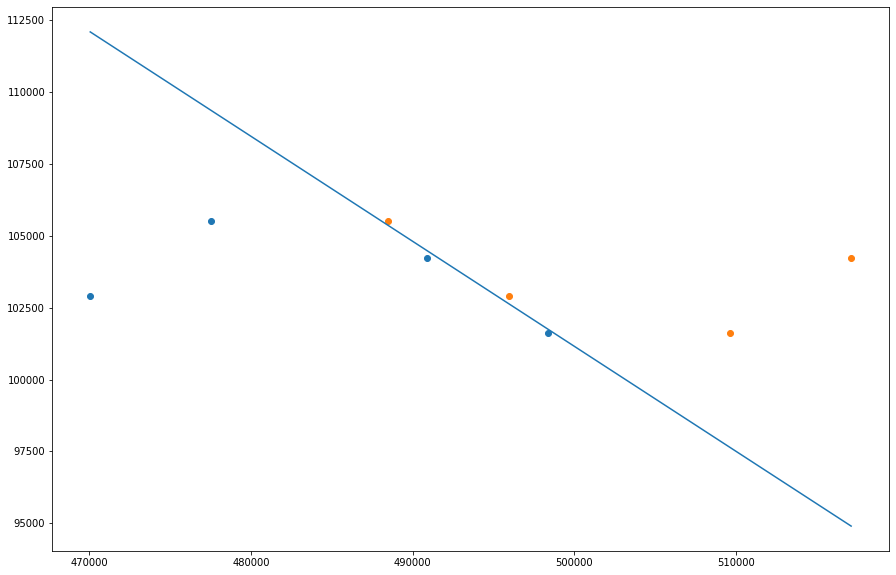

In [46]:
plot(x_L[1], coeff_L[1][0][0], coeff_L[1][0][1])

### Global track

In [47]:
'''def recast3(X):
    L, R, Z = [], [], []
    for i in range(len(X)):
        if i%3==0: L.append(X[i])
        if i%3==1: R.append(X[i])
        if i%3==2: Z.append(X[i])
    return [L,R,Z]'''

'def recast3(X):\n    L, R, Z = [], [], []\n    for i in range(len(X)):\n        if i%3==0: L.append(X[i])\n        if i%3==1: R.append(X[i])\n        if i%3==2: Z.append(X[i])\n    return [L,R,Z]'

In [48]:
'''def recast2(x):
    X, Z = [], []
    for i in x:
        X+=i[0]
        Z+=i[1]
    return [X,Z]'''

'def recast2(x):\n    X, Z = [], []\n    for i in x:\n        X+=i[0]\n        Z+=i[1]\n    return [X,Z]'

In [49]:
'''rdd_global = data.rdd \
    .filter(lambda x: x[0]!=1)\
    .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
    .reduceByKey(lambda x,y: x+y) \
    .mapValues(lambda x: recast3(x)) \
    .mapValues(lambda x: best_fit(x)) \
    .map(lambda x: (x[0][1], [x[1][1], x[1][2]]))\
    .reduceByKey(lambda x, y: recast2([x,y]))'''

'rdd_global = data.rdd     .filter(lambda x: x[0]!=1)    .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])]))     .reduceByKey(lambda x,y: x+y)     .mapValues(lambda x: recast3(x))     .mapValues(lambda x: best_fit(x))     .map(lambda x: (x[0][1], [x[1][1], x[1][2]]))    .reduceByKey(lambda x, y: recast2([x,y]))'

In [50]:
'''rdd_global = rdd_global.unpersist()'''

'rdd_global = rdd_global.unpersist()'

In [51]:
'''rdd_global.take(1)'''

'rdd_global.take(1)'

In [52]:
'''\
    .reduceByKey(lambda x, y: recast2([x,y]))'''

'    .reduceByKey(lambda x, y: recast2([x,y]))'

In [53]:
'''rdd_global = rdd_global.groupByKey() \
    .mapValues(lambda x: recast2(x)) \
    .filter(lambda x: len(x[1][0]) > 2) \
    .mapValues(lambda x: [list(np.polyfit(x[0], x[1], 1)), x[0], x[1]])'''

'rdd_global = rdd_global.groupByKey()     .mapValues(lambda x: recast2(x))     .filter(lambda x: len(x[1][0]) > 2)     .mapValues(lambda x: [list(np.polyfit(x[0], x[1], 1)), x[0], x[1]])'

In [54]:
'''rdd_global.take(5)'''

'rdd_global.take(5)'

In [55]:
'''     \
    .groupByKey() 
    .mapValues(lambda x: recast2(x)) \
    .filter(lambda x: len(x[1][0]) > 2) \
    .mapValues(lambda x: [list(np.polyfit(x[0], x[1], 1)), x[0], x[1]])'''

'         .groupByKey() \n    .mapValues(lambda x: recast2(x))     .filter(lambda x: len(x[1][0]) > 2)     .mapValues(lambda x: [list(np.polyfit(x[0], x[1], 1)), x[0], x[1]])'

In [56]:
def recast2(x):
    X, Z = [], []
    for i in x:
        X+=i[0]
        Z+=i[1]
    return [X,Z]

In [57]:
def plot(x, m, b):
    plt.figure(figsize=(15, 10))
    plt.scatter(x[0], x[1])                 
    
    Xmin = int(min(x[0]))
    Xmax = int(max(x[0]))
    X = range(Xmin, Xmax)
    plt.plot(X, m*X+b, '-')
    plt.show()

In [58]:
G = data.rdd \
        .filter(lambda x: ((x[2]==Orb)&(x[0]!=1))) \
        .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
        .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                     (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                     (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
        .mapValues(lambda x: best_fit(x)) \
        .map(lambda x: (x[0][1], [x[1][1], x[1][2]])) \
        .reduceByKey(lambda x, y: recast2([x,y])) \
        .mapValues(lambda x: [list(np.polyfit(x[0], x[1], 1)), x[0], x[1]]) \
        .reduce(lambda x: x)

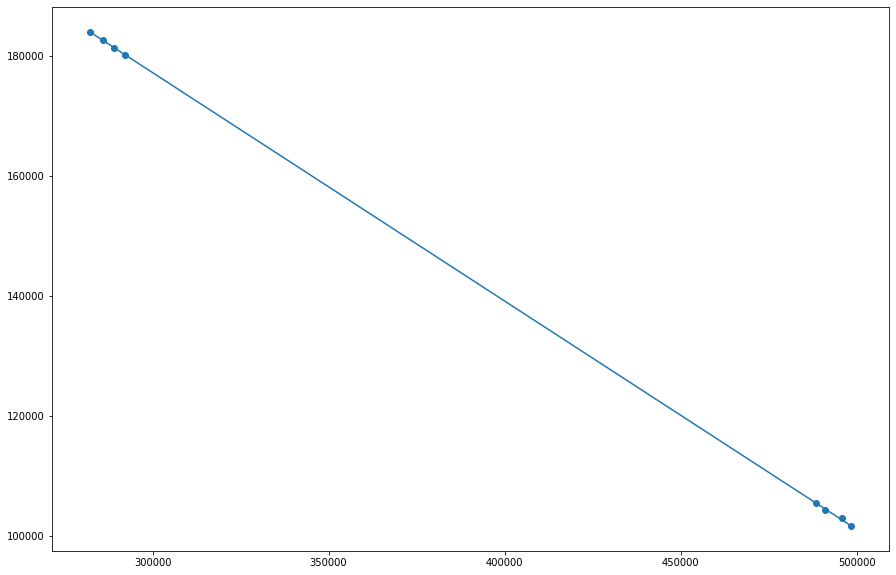

In [59]:
plot([G[1][1], G[1][2]], G[1][0][0], G[1][0][1])

# Angular resolution

In [60]:
def recast2(x):
    X, Z = [], []
    for i in x:
        X+=i[0]
        Z+=i[1]
    return [X,Z]

In [61]:
rdd_global = data.rdd \
                 .filter(lambda x: x[0]!=1) \
                 .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
                 .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                               (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                               (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
                 .mapValues(lambda x: best_fit(x)) \
                 .map(lambda x: (x[0][1], [x[1][1], x[1][2]])) \
                 .reduceByKey(lambda x, y: recast2([x,y])) \
                 .filter(lambda x: len(x[1][0]) > 2) \
                 .mapValues(lambda x: [list(np.polyfit(x[0], x[1], 1)), x[0], x[1]])

In [62]:
rdd_global.take(5)

[(259792768,
  [[-0.6226203505175261, 378847.5614055865],
   [438910.83671875, 443716.9, 444846.83671875],
   [105510.0, 102910.0, 101610.0]]),
 (142809696,
  [[-1.477261819264305, 720401.924854469],
   [417686.705078125,
    419390.33671875,
    415749.66328125,
    417453.294921875,
    473375.2640625,
    471669.604296875,
    474269.97265625,
    471761.2640625],
   [104210.0,
    101610.0,
    105510.0,
    102910.0,
    21330.0,
    22630.0,
    20030.0,
    23930.0]]),
 (221841489,
  [[0.9315732290342914, -331709.55600820365],
   [379375.2625,
    381078.99921875,
    379332.7375,
    468662.16328125,
    465434.16328125,
    469030.0734375,
    465757.1],
   [22630.0, 20030.0, 23930.0, 104210.0, 101610.0, 105510.0, 102910.0]]),
 (377651195,
  [[-0.7234710419782472, 445253.435317661],
   [361164.24609375,
    364481.77265625,
    366662.70078125,
    363300.20078125,
    473244.33671875,
    471621.3734375,
    474804.18984375,
    469523.31015625],
   [183930.0,
    181330.0,
 

In [63]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, FloatType

In [64]:
schema_global = StructType(
    [
        StructField('ORBIT', IntegerType(), False),
        StructField('m_g', DoubleType(), True),
    ]
)
data_global = rdd_global.map(lambda x: [x[0]]+[float(x[1][0][0])]).toDF(schema_global)

schema_local = StructType(
    [
        StructField('CHAMBER', IntegerType(), True),
        StructField('ORBIT', IntegerType(), False),
        StructField('m_l', DoubleType(), True),
    ]
)
data_local = rdd.map(lambda x: [x[0][0],x[0][1]]+[float(x[1][0][0])]).toDF(schema_local)

In [65]:
from pyspark.sql.functions import atan

ang_res = data_local[data_local['CHAMBER']==2]  \
                    .join(data_global, "ORBIT") \
                    .withColumn("theta", atan((col('m_g') - col('m_l'))/(1 + col('m_g')*col('m_l'))))
ang_res.show()

+---------+-------+--------------------+--------------------+--------------------+
|    ORBIT|CHAMBER|                 m_l|                 m_g|               theta|
+---------+-------+--------------------+--------------------+--------------------+
|169832527|      2| -0.6610244095281372| -0.6610244095281372|                 0.0|
|138713984|      2|  1.1751205808547966|  1.0404534693686647|-0.06051433513736...|
| 81108102|      2|-0.02753094908739538| -0.8224525711171491| -0.6607583887157871|
|129578980|      2| 0.05550010867016464|   1.021224763005107|  0.7404554901529031|
|172414775|      2| 0.07589387379196448| 0.07589387379196448|                 0.0|
|247674014|      2|  0.3573193816922412|  1.3804689729506545|   0.600706610678903|
| 46188862|      2| 0.09160441496561784|  1.2663862641716146|  0.8110497616679058|
| 36447650|      2|  0.5149015826193043|  0.5262082447917449|0.008896026050837922|
|292767857|      2|-0.05618929587446288|-0.05618929587446288|                 0.0|
|144

In [68]:
theta = ang_res.select('theta').rdd.flatMap(lambda x: x).collect()  

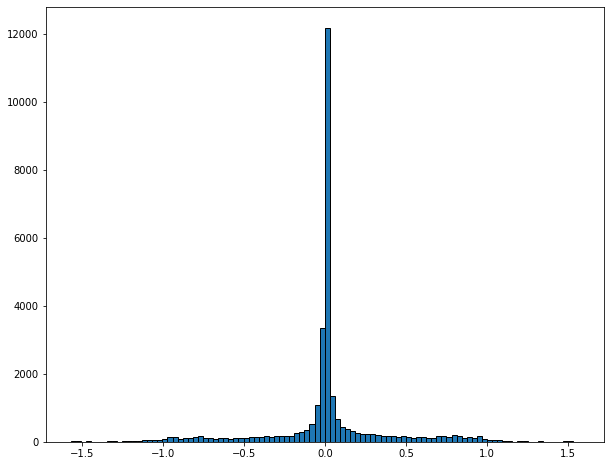

In [77]:
plt.figure(figsize=(10, 8))
plt.hist(theta, bins=100, edgecolor='k') 
#plt.suptitle('Theta', fontsize = 13)
plt.show()

# Total Plot

In [66]:
def mult_plot(L, G, m_L, b_L, m_G, b_G):
    plt.figure(figsize=(15, 10))
    plt.scatter(G[0], G[1])                 
    
    Gmin = int(min(G[0]))
    Gmax = int(max(G[0]))
    X = range(Gmin, Gmax)
    plt.plot(X, m_L*X+b_L, '-', label='Regression Chamber2')
    plt.plot(X, m_G*X+b_G, '-', label='Global Regression')
    plt.legend(prop={'size': 12})
    plt.show()

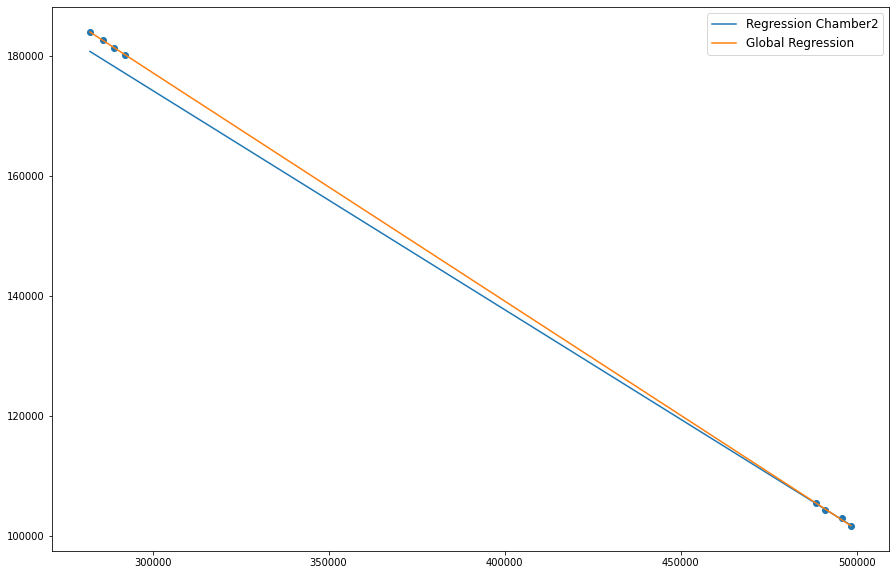

In [67]:
mult_plot(x_L[1], [G[1][1],G[1][2]], coeff_L[1][0][0], coeff_L[1][0][1], G[1][0][0], G[1][0][1])

# STOP

In [ ]:
sc.stop()
spark.stop()

# BATARIA

In [ ]:
for (id, rdd) in sc._jsc.getPersistentRDDs().items():
    rdd.unpersist()
    print("Un {}".format)

In [ ]:
data.createOrReplaceTempView("data_table")
data = spark.sql("SELECT * \
                    FROM (SELECT * FROM data_table WHERE ORBIT IN (SELECT DISTINCT ORBIT FROM data_table WHERE CHAMBER==4)) \
                    WHERE ORBIT IN (SELECT DISTINCT ORBIT \
                                    FROM (SELECT ORBIT, COUNT(*) AS COUNT \
                                           FROM data_table \
                                           GROUP BY (ORBIT) \
                                           HAVING count < 15))")

# Appendix

### Computing the distribution of the muons' arrival time in parallel

In the next cell it is reported the code which aim to obtain the results found in Chapter .

In [ ]:
# manipulate the dataframe
b = data_appendix
b = data.filter(data.CHAMBER==4).select(col("T_HIT_ns"), col('TDC'))
w = Window.partitionBy('TDC').orderBy('T_HIT_ns')
# create a column with shifted data
c = b.withColumn('lead', f.lag('T_HIT_ns', 1).over(w)) \
     .withColumn('t0_diff', f.when(f.col('lead').isNotNull(), f.col('T_HIT_ns') - f.col('lead')).otherwise(f.lit(None))) \
     .withColumn('t0_diff', col('t0_diff')*1e-9)              # compute the between-muons' time and convert in seconds
d = c.select("t0_diff").toPandas()                            # move datat to a Pandas dataframe

# executing the fit
hist_val, bin_edges = np.histogram(d.t0_diff.dropna(), bins=25)#, density=True)
middle_edges = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
def exponential(x,A,gamma):
    return A*np.exp(-gamma*x)
par, cov = curve_fit(exponential, middle_edges, hist_val, p0=(25000,1.5e-9), method='lm')

# print results
print('Fit parameters :')
display(Math(fr'A = ({par[0]*1e-3:.1f} \pm {np.sqrt(cov[0,0])*1e-3:.1f}) \cdot 10^3 '))
display(Math(fr'\gamma = ({par[1]:.3f} \pm {np.sqrt(cov[1,1]):.3f} ) \quad Hz'))
print('Mean time between two muons :')
display(Math(fr'\Delta T = ({1/(par[1]):.3f} \pm {np.sqrt(cov[1,1])/(par[1]):.3f} ) \quad s'))

# plot results
plt.figure(figsize=(14,7))
x_plot = np.linspace(3,200,500)
y_plot = exponential(x_plot,*par)
plt.hist(d.t0_diff, bins=25, color='darkslategray', label='Experimental data')
plt.plot(x_plot, y_plot, 'brown', label='Fit function')
plt.title("Muon's arrival time distribution exploiting parallel computing")
plt.xlabel('Time  [s]')
plt.ylabel('Counts')
plt.xticks(ticks=bin_edges)
plt.xlim(-1,160)
plt.legend()
plt.show()

We can note that the histogram and the $\gamma$ parameter obtained are sensibly different from the ones obtained executing the computation only on the master resources. This is caused by the line "w = Window.partitionBy('TDC').orderBy('T_HIT_ns')", where we impose a data partiton based on the TDC channel. Consequently, when sorting arrival times and computing the difference between them, the difference are not computed between consequent muons (because their information stands in different partitions) and this results in greater between-muons arrival time, which causes the histogram to be scaled in the x-axis.

Note that executing the partition on a different column, like FPGA, CHAN or CHAMBER will results in allocate all data informations on a single partition. Providing no column to the partitionBy() function also causes Spark to save every record in a single virtual machine, thus losing all the advantages of exploiting a computing cluster.